# Import modules, data

In [1]:
import pandas as pd
from settings import settings
import matplotlib.pyplot as plt
import numpy as np
import datetime
import geopandas as gpd
import json
from topojson import Topology

In [2]:
Sale = pd.read_csv(settings.sale_table)
Property = pd.read_csv(settings.property_table)

In [3]:
Sale.head()

,id,sale_date,net_sale_price
0,00000033c,2024-03-25,1065000
1,000000hjd,2024-06-14,710000
2,000000hjd,2010-07-01,340000
3,000000hjd,2008-01-24,137000
4,000000j7c,2024-06-13,743000


In [4]:
Property.head(2)

,id,type,bedrooms,bathrooms,floor_area,land_area,land_area_unit,floor_area_unit,bathroom_ensuite_count,bathroom_wc_count,...,street_name,suburb,district,region,postcode,latitude,longitude,latest_sale_listing_date,latest_sale_date,last_update
0,4n90vsrq,property,3,1,104,810.0,SQM,SQM,0.0,0.0,...,Dungannon Street,Ranfurly,Central Otago,Central Otago / Lakes District,9332,-45.126353,170.105869,2024-02-15,2024-04-10,2024-11-16
1,p5jtz1rq,property,3,2,210,2259.0,SQM,SQM,0.0,0.0,...,Chirnside Terrace,Ranfurly,Central Otago,Central Otago / Lakes District,9398,-45.272840,170.047648,2023-02-24,2024-08-30,2024-11-16


In [5]:
# Property.columns
Prop_data = Property[['id', 'suburb', 'district', 'region', 'postcode', 'latitude', 'longitude']]
Prop_data.head(2)

,id,suburb,district,region,postcode,latitude,longitude
0,4n90vsrq,Ranfurly,Central Otago,Central Otago / Lakes District,9332,-45.126353,170.105869
1,p5jtz1rq,Ranfurly,Central Otago,Central Otago / Lakes District,9398,-45.272840,170.047648


In [6]:
Data = Sale.merge(Prop_data, how = "left", left_on = 'id', right_on = 'id')
Data.head(3)

,id,sale_date,net_sale_price,suburb,district,region,postcode,latitude,longitude
0,00000033c,2024-03-25,1065000,Mangakakahi,Rotorua,Bay of Plenty,3015,-38.131936,176.231633
1,000000hjd,2024-06-14,710000,Glenholme,Rotorua,Bay of Plenty,3010,-38.145476,176.240918
2,000000hjd,2010-07-01,340000,Glenholme,Rotorua,Bay of Plenty,3010,-38.145476,176.240918


In [49]:
# Create a new DataFrame explicitly to avoid slicing issues
Data_model = Data[['sale_date', 'net_sale_price', 'region']].copy()

# Convert 'sale_date' to datetime and extract year and month as 'YYYY-MM'
Data_model['sale_date'] = pd.to_datetime(Data_model['sale_date']).dt.strftime('%Y-%m')

# Group by 'sale_date' and 'region', then calculate the mean of 'net_sale_price'
grouped_data = Data_model.groupby(['sale_date', 'region'])['net_sale_price'].mean().reset_index()

grouped_data.head()


,sale_date,region,net_sale_price
0,1980-01,Coromandel,41000.0
1,1980-01,Southland,13000.0
2,1980-02,Bay of Plenty,4500.0
3,1980-02,Canterbury,59000.0
4,1980-02,Manawatu / Whanganui,70000.0


       sale_date  net_sale_price      region
145440   2024-01      1250000000  Canterbury


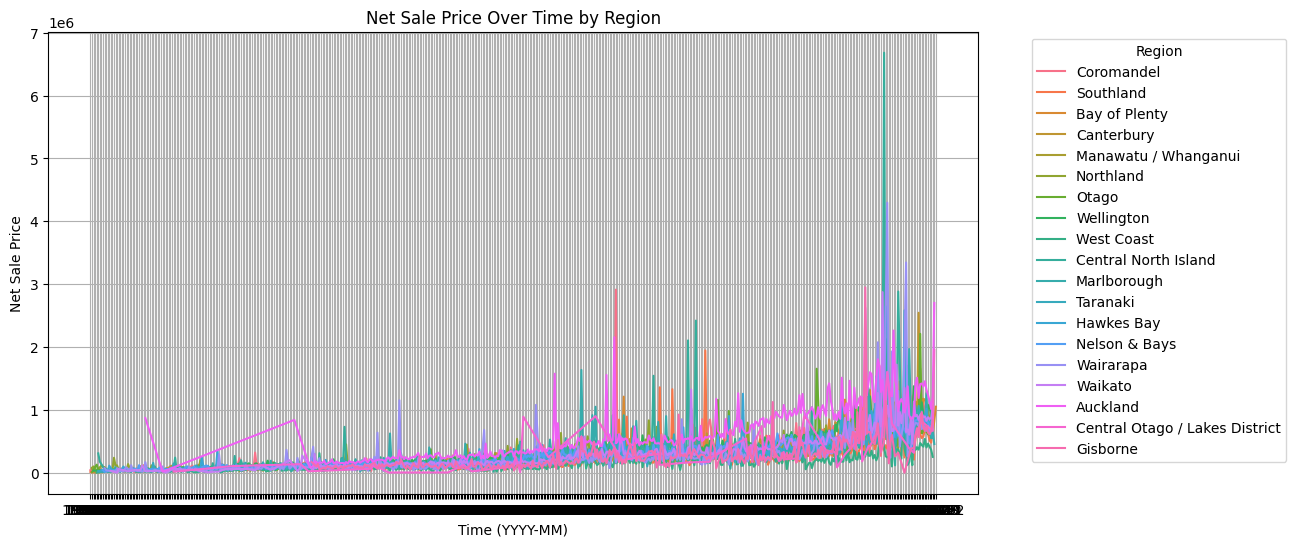

In [ ]:
# Calculate the 99th percentile for each sale_date
percentiles = Data_model.groupby('sale_date')['net_sale_price'].quantile(0.99)


print(Data_model[Data_model['net_sale_price'] == max(Data_model['net_sale_price'])])

# Join the 99th percentile thresholds back to the original DataFrame
Data_model = Data_model.merge(percentiles, on='sale_date', suffixes=('', '_99th'))

# Filter out values above the 99th percentile for each sale_date
Data_model_filtered = Data_model[Data_model['net_sale_price'] <= Data_model['net_sale_price_99th']]

Data_model_filtered = Data_model_filtered.drop(columns=['net_sale_price_99th'])


# Group by 'sale_date' and 'region', and calculate mean net sale price
regional_data = Data_model.groupby(['sale_date', 'region'])['net_sale_price'].mean().reset_index()

# Plot data for all regions
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=regional_data, x='sale_date', y='net_sale_price', hue='region')
plt.title('Net Sale Price Over Time by Region')
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Net Sale Price')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


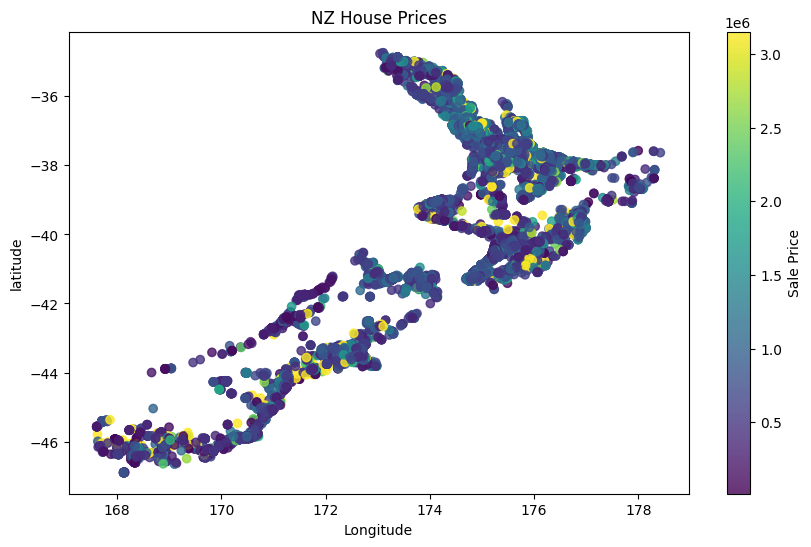

In [7]:
min_price = np.percentile(Data['net_sale_price'], 1)
max_price = np.percentile(Data['net_sale_price'], 99)

Data['net_sale_price_capped'] = Data['net_sale_price'].clip(min_price, max_price)

Data = Data[pd.to_datetime(Data['sale_date']).dt.year == 2024]

plt.figure(figsize = (10,6))
scatter = plt.scatter(Data['longitude'],
            Data['latitude'],
            c = Data['net_sale_price_capped'],
            cmap = "viridis",
            alpha = 0.8)

plt.colorbar(scatter, label = 'Sale Price')

plt.xlabel('Longitude')
plt.ylabel('latitude')
plt.title('NZ House Prices')

plt.show()

In [8]:
# Load TopoJSON file
with open(settings.regional_map, 'r') as file:
    topo_data = json.load(file)

object_name = 'Regional Councils'

#Convert TopoJSON to GeoDataFrame
topology = Topology(topo_data, object_name = object_name)
geojson_data = topology.to_geojson()

# If the result is a string, convert it to JSON
if isinstance(geojson_data, str):
    geojson_data = json.loads(geojson_data)

# Convert GeoJSON to GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

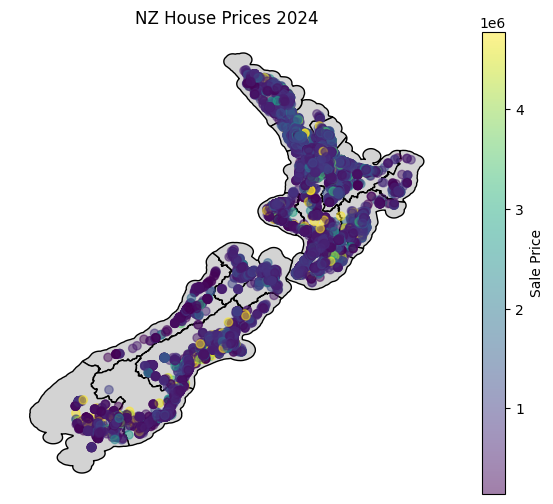

In [9]:
min_price = np.percentile(Data['net_sale_price'], 1)
max_price = np.percentile(Data['net_sale_price'], 99)

Data['net_sale_price_capped'] = Data['net_sale_price'].clip(min_price, max_price)

Data = Data[pd.to_datetime(Data['sale_date']).dt.year == 2024]

# Set the font to 'DIN'
#plt.rcParams['font.family'] = 'DIN'

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the TopoJSON map
gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Overlay the scatter plot on the same axis
scatter = ax.scatter(
    Data['longitude'],
    Data['latitude'],
    c=Data['net_sale_price_capped'],
    cmap="viridis",
    alpha=0.5
)

# Add a color bar and labels
plt.colorbar(scatter, ax=ax, label='Sale Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NZ House Prices 2024')

# Remove axis and bounding box
ax.set_axis_off()  # Removes the axis
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)  # Removes the bounding box

# Show the combined plot
plt.show()

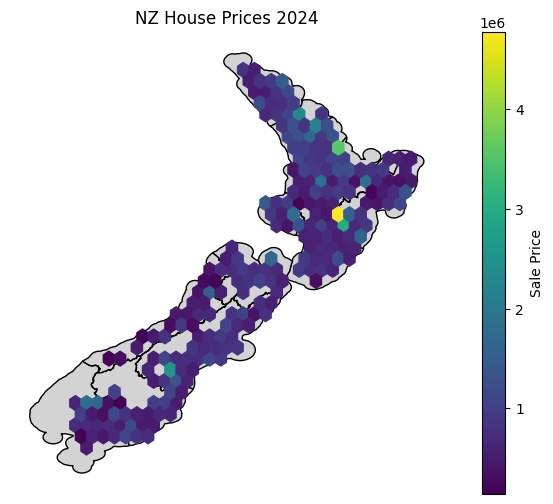

In [ ]:
import matplotlib.pyplot as plt

# Set the font to 'DIN'
#plt.rcParams['font.family'] = 'DIN'

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the TopoJSON map
gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Create a hexbin plot instead of a scatter plot for the heatmap effect
hb = ax.hexbin(
    Data['longitude'],
    Data['latitude'],
    C=Data['net_sale_price_capped'],
    gridsize=30,  # Adjust the grid size for hexagons
    cmap='viridis',  # Color map for the heatmap
    mincnt=1  # Avoid empty hexagons
)

# Add a color bar for the heatmap
plt.colorbar(hb, ax=ax, label='Sale Price')

# Remove axis and bounding box
ax.set_axis_off()  # Removes the axis
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)  # Removes the bounding box

# Title and labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NZ House Prices 2024')

# Show the plot
plt.show()
